## Chapter 4 - Applications

Panit (Luke) Arunanondchai

The coverage is the frequency of observed exceedances. Multiplying this frequency with the total number of observations in the evaluation window thus gives you the numer of observed exceedances.

### Comovement between predicted vol and VaR
The value-at-risk plots shows substantial time-variation in the downside risk. This time-variation is mostly driven by the time-variation in the return volatility. In this exercise, you will verify that this is the case for the daily Microsoft returns by plotting in one figure both the 5% value-at-risk and the estimated volatility. The object garchroll holding the output of a rolling GARCH estimation is already available to you in the console.

In [1]:
library(rugarch)
load("msftret.Rdata")
# Use ugarchroll for rolling estimation of the GARCH model 
garchspec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                       variance.model = list(model = "gjrGARCH"),
                       distribution.model = "sstd")

garchroll <- ugarchroll(garchspec, data = msftret , 
        n.start = 2500, refit.window = "moving",  refit.every = 100)

Warning message:
"package 'rugarch' was built under R version 3.5.2"Loading required package: parallel

Attaching package: 'rugarch'

The following object is masked from 'package:stats':

    sigma



Warning message:
"package 'xts' was built under R version 3.5.2"Loading required package: zoo
Warning message:
"package 'zoo' was built under R version 3.5.2"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



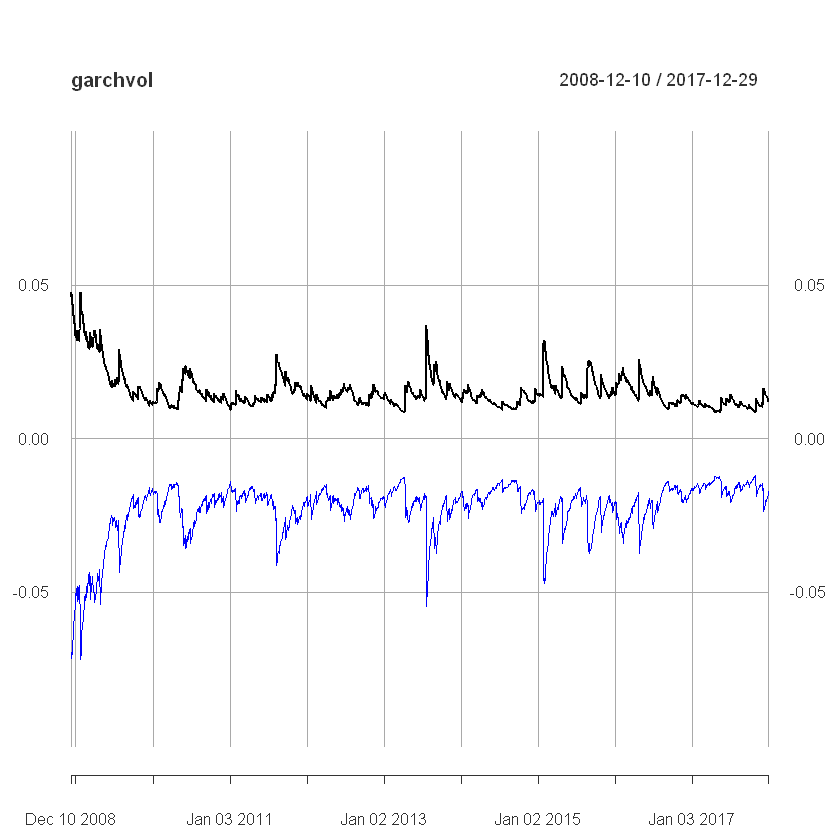

In [2]:
library(xts)
# Extract the dataframe with predictions from the rolling GARCH estimation
garchpreds <- as.data.frame(garchroll)

# Extract the 5% VaR 
garchVaR <- quantile(garchroll, prob = 0.05)

# Extract the volatility from garchpreds
garchvol <- xts(garchpreds$Sigma, order.by = time(garchVaR))

# Analyze the comovement in a time series plot
garchplot <- plot(garchvol, ylim = c(-0.1, 0.1))
garchplot <- addSeries(garchVaR, on = 1, col = "blue")
plot(garchplot, main = "Daily vol and 5% VaR")

Notice the high comovement between the two series. The intuition is that, if volatility shoots up, you risk to lose more money. That's why also the value-at-risk becomes more extreme.

### Sensitivity of coverage to distribution model

A GARCH model is a collection of assumptions regarding the mean, the variance and the distribution. A naive approach is to assume a normal distribution. This model is not a realistic model in case of analyzing stock returns, like the daily Microsoft returns. A skewed student t distribution is a better description of its distribution. You will see that this becomes clear by comparing the coverage of the 5% value-at-risk under the normal distribution and skewed student t distribution.

In [3]:
# Take a default specification a with a normal and skewed student t distribution
normgarchspec <- ugarchspec(distribution.model = "norm")
sstdgarchspec <- ugarchspec(distribution.model = "sstd")

# Do rolling estimation
normgarchroll <- ugarchroll(normgarchspec, data = msftret, 
                            n.start = 2500, refit.window = "moving", refit.every = 2000)
sstdgarchroll <- ugarchroll(sstdgarchspec, data = msftret, 
                            n.start = 2500, refit.window = "moving", refit.every = 2000)

# Compute the 5% value at risk
normgarchVaR <- quantile(normgarchroll, prob = 0.05)
sstdgarchVaR <- quantile(sstdgarchroll, prob = 0.05)

# Compute the coverage
actual <- xts(as.data.frame(normgarchroll)$Realized,time(normgarchVaR))
mean(actual<normgarchVaR)
mean(actual<sstdgarchVaR)

[1] 0.02412281

[1] 0.04429825

The coverage is clearly better when using a skewed student t distribution. Modelling correctly the distribution is of utmost important for getting the quantiles (and thus the value-at-risk) right. Note that in the implementation we took 2000 observations to reduce the computation time in this example. In practice you will be able to improve performance by re-estimating at a higher frequency.

### Use in production

In a corporate environment, there is often a distinction between the stage of model engineering and the stage to using the model in production. When using the model in production, it may be that the model is not re-estimated at each stage. You then use the model with fixed coefficients but integrating on each prediction day the new data. The function **ugarchfilter()** is designed to complete this task.

In this exercise you use a model fitted on the January 1989 till December 2007 daily S&P 500 returns to make a prediction of the future volatility in a turbulent period (September 2008) and a stable period (September 2017). The model has already been specified as is available as garchspec in the R console.

In [4]:
load("sp500prices.Rdata")
library(PerformanceAnalytics)
sp500ret = Return.calculate(xts(sp500prices),method="discrete")[-1]

Warning message:
"package 'PerformanceAnalytics' was built under R version 3.5.2"
Attaching package: 'PerformanceAnalytics'

The following object is masked from 'package:graphics':

    legend



In [5]:
head(sp500ret)

           GSPC.Adjusted
1989-01-04   0.014964931
1989-01-05   0.002075715
1989-01-06   0.002357069
1989-01-09   0.001104493
1989-01-10  -0.002135405
1989-01-11   0.005813556

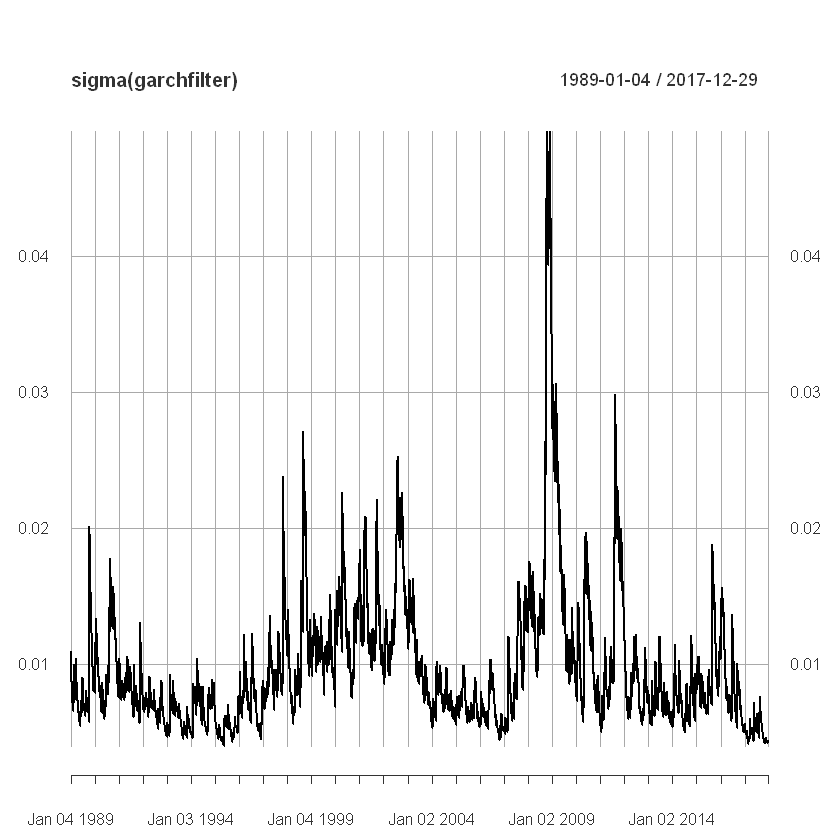

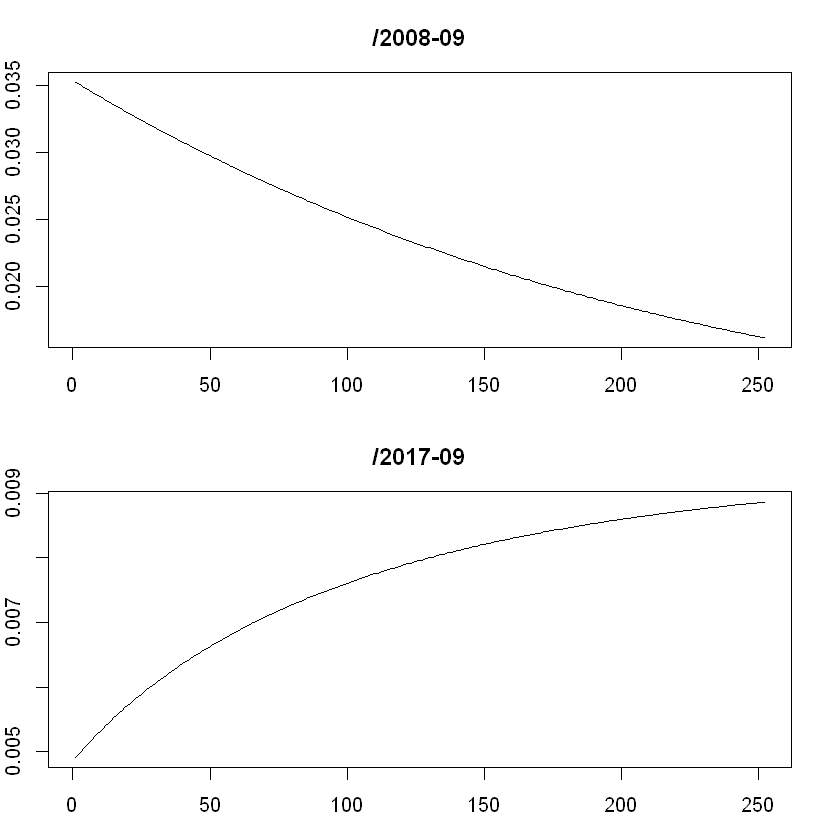

In [6]:
# Estimate the model
garchfit <- ugarchfit(data = sp500ret["/2006-12"], spec = garchspec)

# Fix the parameters
progarchspec <- garchspec
setfixed(progarchspec) <- as.list(coef(garchfit))

# Use ugarchfilter to obtain the estimated volatility for the complete period
garchfilter <- ugarchfilter(data = sp500ret, spec = progarchspec)
plot(sigma(garchfilter))

# Compare the 252 days ahead forecasts made at the end of September 2008 and September 2017
garchforecast2008 <- ugarchforecast(data = sp500ret["/2008-09"], fitORspec = progarchspec, n.ahead = 252)
garchforecast2017 <- ugarchforecast(data = sp500ret["/2017-09"], fitORspec = progarchspec, n.ahead = 252)
par(mfrow = c(2,1), mar = c(3,2,3,2))
plot(sigma(garchforecast2008), main = "/2008-09", type = "l")
plot(sigma(garchforecast2017), main = "/2017-09", type = "l")

Note that the on the long run the volatility is predicted to return to its average level. This explains why the predicted volatility at T+252 is similar in September 2008 and 2017.

### Use in simulation

Time to get your hands dirty with an actual simulation of stock returns and corresponding volatility and prices. The model to simulate returns is simgarchspec available in the R console.

In [14]:
simgarchspec <- ugarchspec(mean.model = list(armaOrder = c(1,0)),
                       variance.model = list(model = "gjrGARCH"),
                       distribution.model = "sstd")

setfixed(simgarchspec) <- list("mu"     = 0.000522,
                               "ar1"    = -0.0386,
                               "omega"  = 2.1e-06,
                               "alpha1" = 0.0386,
                               "beta1"  = 0.935,
                               "gamma1" = 0.0496,
                               "skew"   = 1.04,
                               "shape"  = 4.35)

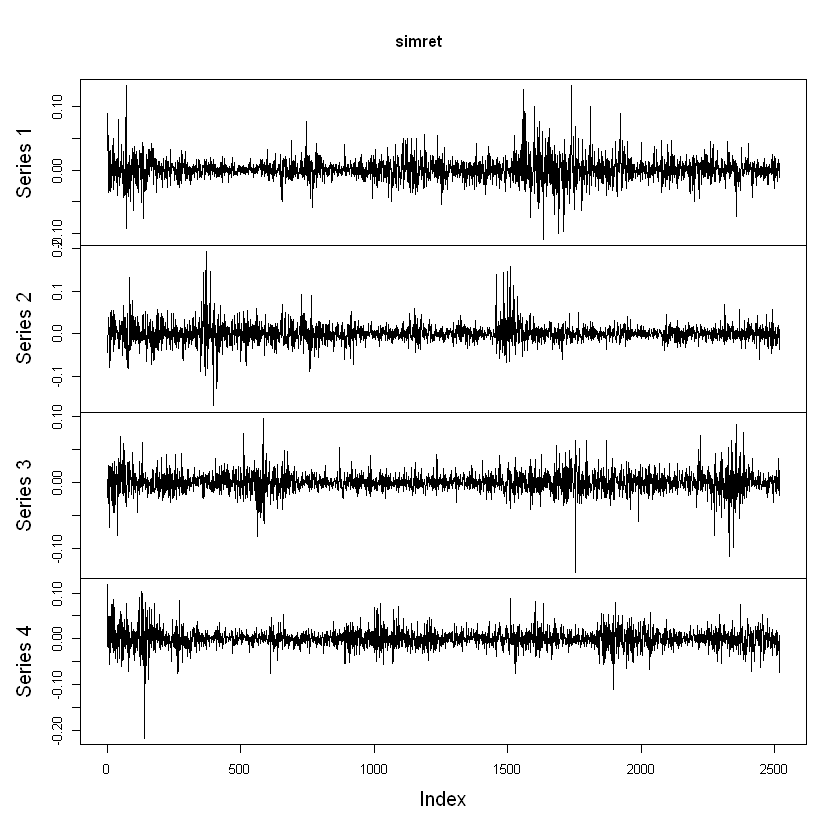

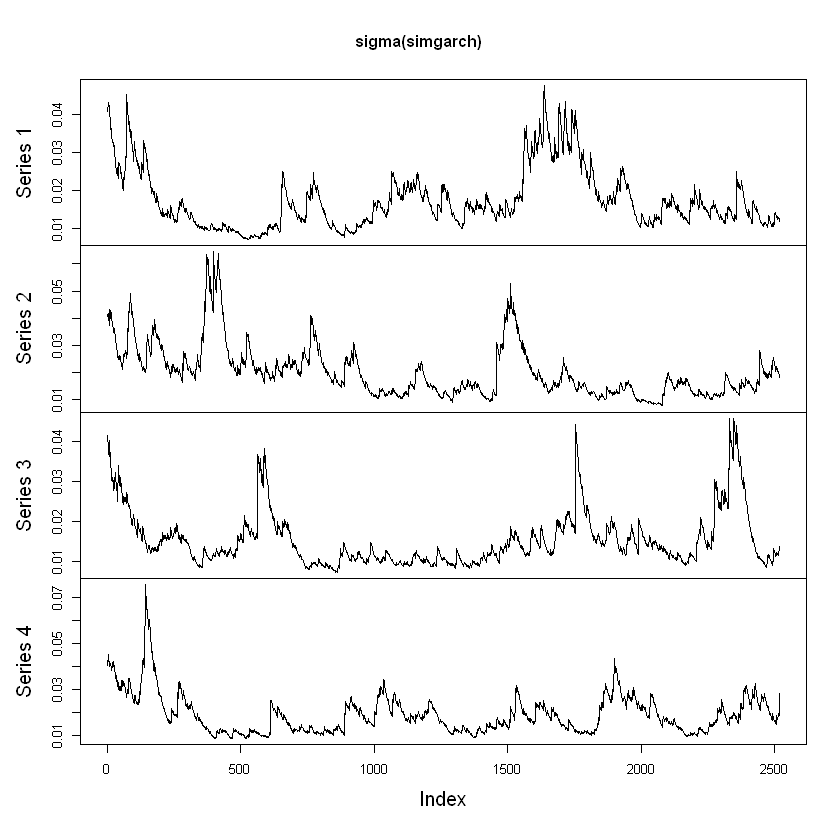

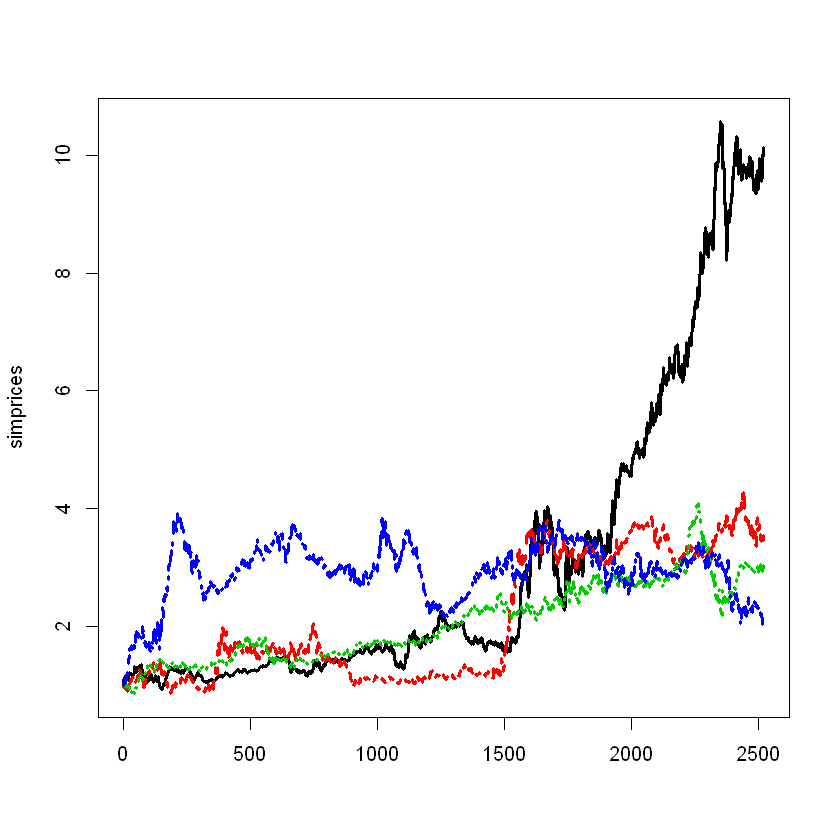

In [16]:
# Complete the code to simulate 4 time series of 10 years of daily returns
simgarch <- ugarchpath(spec=simgarchspec, m.sim = 4, n.sim = 10*252,  rseed = 210) 

# Plot the simulated returns of the four series
simret <- fitted(simgarch)
plot.zoo(simret)
plot.zoo(sigma(simgarch))

# Compute the corresponding simulated prices and plot them
simprices <- exp(apply(simret, 2, "cumsum"))
matplot(simprices, type = "l", lwd = 3)

Wonderful! You are now an expert user of GARCH model in a univariate setting. But what do GARCH models imply about the dependence between financial returns? 

### Robustniks
Robustniks are researchers who think that every model is wrong and no model can be expected to explain all the return observations. Robustniks make their volatility predictions in such a way that their prediction remains reliable even when there are outliers in the data or when the model changes over time.

if your returns are affected by outliers, also the maximum likelihood estimation of the various models will be affected. Garbage in, garbage out. When all models become unreliable due to the outliers, model averaging is not a solution. Instead a robust approach should be used that either cleans the data directly or uses robust estimation methods.

### Starting values

The estimation of a GARCH model requires to optimize the likelihood. This optimization may fail in case of bad starting values. Fortunately, Alexios Ghalanos, the author of the R package rugarch, did a great job in setting the optimization defaults such that the optimization is accurate in most of the cases. If you have a doubt, you can use the method setstart() to try your own starting values and verify that it leads to a similar result in terms of estimated parameters and likelihood.

Here you can test this in case of the daily EUR/USD returns in EURUSDret and assuming a constant mean standard GARCH model with Student t distribution. The model specification is available in the console as garchspec.

In [17]:
load("EURUSDret.Rdata")
garchspec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                       variance.model = list(model = "sGARCH"),
                       distribution.model = "std")

In [18]:
# Estimate using default starting values
garchfit <- ugarchfit(data=EURUSDret,spec=garchspec)

# Print the estimated parameters and the likelihood
coef(garchfit)
likelihood(garchfit)

# Set other starting values and re-estimate
setstart(garchspec) <- list(alpha1 = 0.05, beta1 = 0.9, shape = 6) 
garchfit <- ugarchfit(data=EURUSDret,spec=garchspec)

# Print the estimated parameters and the likelihood
coef(garchfit)
likelihood(garchfit)

mu         omega        alpha1         beta1         shape 
-3.562136e-05  8.005123e-08  3.097322e-02  9.674496e-01  8.821902e+00

[1] 18528.77

mu         omega        alpha1         beta1         shape 
-3.373396e-05  8.593560e-08  3.106384e-02  9.670584e-01  8.920289e+00

[1] 18528.75

You can see that changing the starting values has slightly decreased the likelihood function. The default approach is thus recommended.